In [1]:
import os
import matplotlib.pyplot as plt
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
imagefiles = [os.path.join(root, filename)
          for root, dirnames, filenames in os.walk('idb')
          for filename in filenames if filename.endswith('.png')]

In [3]:
imagefiles

['idb\\$LUDGEHAMMER\\A ZIP AND A DOUBLE CUP\\extralarge.png',
 'idb\\$LUDGEHAMMER\\A ZIP AND A DOUBLE CUP\\large.png',
 'idb\\$LUDGEHAMMER\\A ZIP AND A DOUBLE CUP\\medium.png',
 'idb\\$LUDGEHAMMER\\A ZIP AND A DOUBLE CUP\\small.png',
 'idb\\Air Tycoon\\Winter Purple\\extralarge.png',
 'idb\\Air Tycoon\\Winter Purple\\large.png',
 'idb\\Air Tycoon\\Winter Purple\\medium.png',
 'idb\\Air Tycoon\\Winter Purple\\small.png',
 'idb\\Anamanaguchi\\Endless Fantasy\\extralarge.png',
 'idb\\Anamanaguchi\\Endless Fantasy\\large.png',
 'idb\\Anamanaguchi\\Endless Fantasy\\medium.png',
 'idb\\Anamanaguchi\\Endless Fantasy\\small.png',
 'idb\\araabMUZIK\\Electronic Dream\\extralarge.png',
 'idb\\araabMUZIK\\Electronic Dream\\large.png',
 'idb\\araabMUZIK\\Electronic Dream\\medium.png',
 'idb\\araabMUZIK\\Electronic Dream\\small.png',
 'idb\\ASAP Rocky\\LiveLoveA$AP\\extralarge.png',
 'idb\\ASAP Rocky\\LiveLoveA$AP\\large.png',
 'idb\\ASAP Rocky\\LiveLoveA$AP\\medium.png',
 'idb\\ASAP Rocky\\LiveLove

In [19]:
imagefiles[25].split("\\")
len(imagefiles)//4

109

for each image file i want to
add the flattened scaled down to 28x28 image to Xs
add unique id to ys and update a y-to-name fxn with artist - album

In [8]:
from skimage import io
from skimage.transform import resize

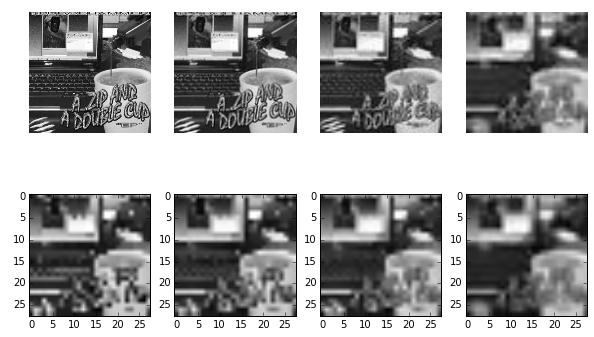

In [8]:
# let's try it on first image
test_image = [None]*4
figs, axes = plt.subplots(2, 4, figsize=(10, 6))

for i in range(4):
    test_image[i] = io.imread(imagefiles[i],as_grey=True)
    axes[0,i].imshow(test_image[i],cmap=plt.cm.gray)
    axes[0,i].axis('off')
    axes[1,i].imshow(resize(test_image[i],(28,28)),cmap=plt.cm.gray)

    

In [9]:
no_samples = len(imagefiles)
X = [None]*no_samples
y = np.repeat(range(no_samples//4),4)
y_to_name = [None]*(no_samples//4)

for i in range(no_samples//4):
    s = imagefiles[i*4].split("\\")
    y_to_name[i] = s[1] + " - " + s[2]

for i in range(no_samples):
    testim = io.imread(imagefiles[i],as_grey=True)
    X[i] = resize(testim,(28,28))

In [10]:
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

In [11]:
# ok now to test it with the learning from before
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Conv2DLayer
from lasagne.layers import MaxPool2DLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from lasagne.layers import get_all_params
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective

In [13]:
X -= X.mean()
X /= X.std()
X = X.reshape(
        -1,  # number of samples, -1 makes it so that this number is determined automatically
        1,   # 1 color channel, since images are only black and white
        28,  # first image dimension (vertical)
        28,  # second image dimension (horizontal)
    )

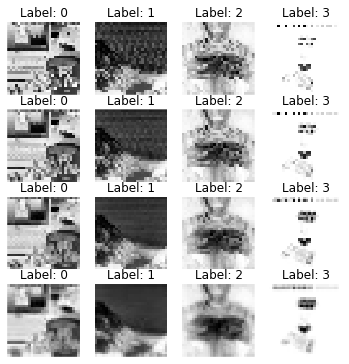

In [15]:
figs, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(-X[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("Label: {}".format(y[i + 4 * j]))
        axes[i, j].axis('off')

In [35]:
layers0 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    (DenseLayer, {'num_units': 109, 'nonlinearity': softmax}),
]
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses
net0 = NeuralNet(
    layers=layers0,
    max_epochs=10,

    #update=adam,
    update_learning_rate=0.01,
    #objective=regularization_objective,
    #objective_lambda2=0.0025,

    train_split=TrainSplit(eval_size=0.1),
    verbose=2,
)

In [31]:
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()

In [36]:
net0.initialize()

layer_info(net0)

# Neural Network with 360173 learnable parameters

## Layer information

name         size        total    cap.Y    cap.X    cov.Y    cov.X
-----------  --------  -------  -------  -------  -------  -------
input0       1x28x28       784   100.00   100.00   100.00   100.00
conv2d1      32x28x28    25088   100.00   100.00    10.71    10.71
conv2d2      32x28x28    25088    60.00    60.00    17.86    17.86
conv2d3      32x28x28    25088    42.86    42.86    25.00    25.00
conv2d4      32x28x28    25088    33.33    33.33    32.14    32.14
conv2d5      32x28x28    25088    27.27    27.27    39.29    39.29
conv2d6      32x28x28    25088    23.08    23.08    46.43    46.43
conv2d7      32x28x28    25088    20.00    20.00    53.57    53.57
maxpool2d8   32x14x14     6272    20.00    20.00    53.57    53.57
conv2d9      64x14x14    12544    31.58    31.58    67.86    67.86
conv2d10     64x14x14    12544    26.09    26.09    82.14    82.14
conv2d11     64x14x14    12544    22.22    22.22    96.4

In [37]:
net0.fit(X, y)

# Neural Network with 360173 learnable parameters

## Layer information

name         size        total    cap.Y    cap.X    cov.Y    cov.X
-----------  --------  -------  -------  -------  -------  -------
input0       1x28x28       784   100.00   100.00   100.00   100.00
conv2d1      32x28x28    25088   100.00   100.00    10.71    10.71
conv2d2      32x28x28    25088    60.00    60.00    17.86    17.86
conv2d3      32x28x28    25088    42.86    42.86    25.00    25.00
conv2d4      32x28x28    25088    33.33    33.33    32.14    32.14
conv2d5      32x28x28    25088    27.27    27.27    39.29    39.29
conv2d6      32x28x28    25088    23.08    23.08    46.43    46.43
conv2d7      32x28x28    25088    20.00    20.00    53.57    53.57
maxpool2d8   32x14x14     6272    20.00    20.00    53.57    53.57
conv2d9      64x14x14    12544    31.58    31.58    67.86    67.86
conv2d10     64x14x14    12544    26.09    26.09    82.14    82.14
conv2d11     64x14x14    12544    22.22    22.22    96.4

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:417: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000000000AFFBC50>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x000000000AFFBBE0>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'pad': 1, 'num_filters': 32, 'filter_size': (3, 3)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'pad': 1, 'num_filters': 32, 'filter_size': (3, 3)}), (<class 'lasagne.la...s.dense.DenseLayer'>, {'nonlinearity': <function softmax at 0x000000000AE698C8>, 'num_units': 109})],
     loss=None, max_epochs=10, more_params={},
     objective=<function objective at 0x000000000B01F598>,
     objective_loss_function=<function categorical_crossentropy at 0x000000000AFA8510>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x0000000012244198>],
     on_training_finished=[],
     on_training_started=[<nolearn.l

In [22]:
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

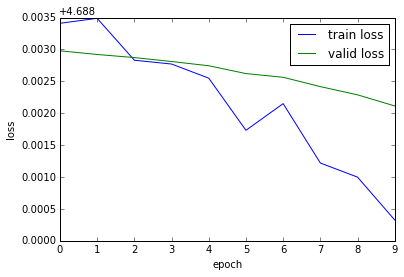

In [38]:
plot_loss(net0)


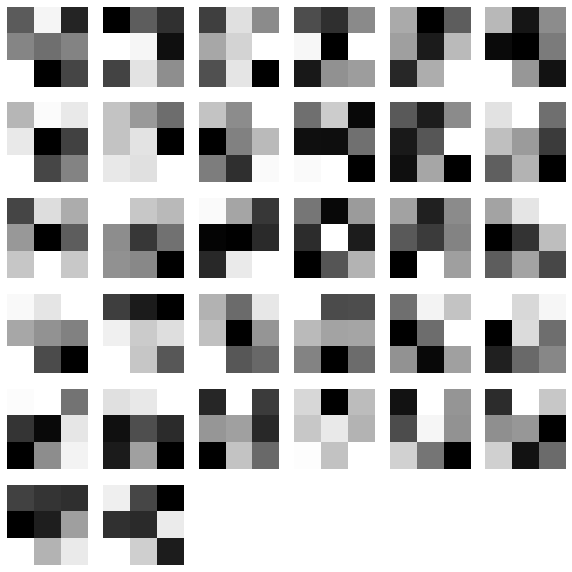

In [39]:
plot_conv_weights(net0.layers_[1], figsize=(10, 10))


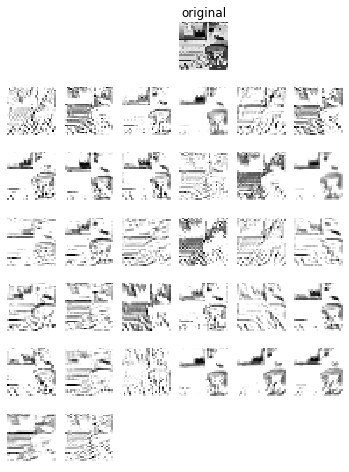

In [40]:
x = X[0:1]
plot_conv_activity(net0.layers_[1], x)
